This notebook calculates the equations of motion for a compound pendulum (ie not just a point mass)
and simulates the dynamics using `scipy.odient`. The pendulum is modeled as a uniform density rod with friction at the pivot. 

This notebook is loosely based on [this article](http://nbviewer.jupyter.org/github/pydy/pydy/blob/master/examples/differential_drive/Differential%20Drive.ipynb)
and I looked at [the sympy test cases for more examples of using LagrangesMethod](https://github.com/sympy/sympy/blob/master/sympy/physics/mechanics/tests/test_lagrange.py).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from sympy import symbols, lambdify, Dummy, integrate
from sympy.physics.mechanics import *

%matplotlib inline
init_vprinting()

In [2]:
m = symbols('m')   # mass of the pendulum
l = symbols('l')   # length of the pendulum
g = symbols('g')   # acceleration due to gravity
mu = symbols('mu') # coefficient of friction

q = dynamicsymbols('theta') # q is the state vector
dq = q.diff() # and dq is the velocity

In [3]:
N = ReferenceFrame('N') # Inertial Reference Frame
O = Point('O') # Define a world coordinate origin
O.set_vel(N, 0) # set the velocity of the origin to zero in the world frame

# create a reference frame for the pendulum
R = N.orientnew('R', 'Axis', [q, N.z])
R.set_ang_vel(N, dq*N.z) # set the angular velocity of R to dq

# define a point for the center of mass of the pendulum
C = O.locatenew('C', R.x*l/2.)
C.v2pt_theory(O, N, R) # solve for and set the velocity of C

In [4]:
# the force of friction acts on the pendulums reference frame and is proportional to dq
force_of_friction = (R, -dq*mu*R.z)

# calculate the inertia (modeled as a uniform density stick rotating at the end)
# integrate the density (m/l) time the radius squared along the length of the segment
x = symbols('x')
I_component = integrate(x**2 * m/l, (x, 0, l))
# the pendulum is a 3d model, but has no Ixx inertia because it's zero diamter
I = inertia(R, 0, I_component, I_component)

# and define a rigid body for the segment
segment = RigidBody('Segment', C, R, m, (I , O))

# calculate the potential energy of the segment
h = (C.pos_from(O)).express(N).args[0][0][0]
segment.potential_energy = m*g*h

In [5]:
L = Lagrangian(N, segment) # create the lagrangian L = T - V
lm = LagrangesMethod(L, [q], forcelist=[force_of_friction], frame=N)
le = lm.form_lagranges_equations()
rhs = lm.rhs() # extract the right hand side

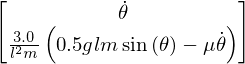

In [6]:
# take a look at the resulting equations of motion. theta changes with angular velocity
# (theta_dot), and the angular velocity changes as a function of the current angle,
# (force from gravity) and with the current angular velocity (force from friction)
rhs

In [7]:
class RHSWrapper():
    def __init__(self, rhs, dynamics, params=[], values=[]):
        self.rhs = rhs
        self.dynamics = dynamics
        self.params = params
        self.values = values
        
        # substitute dummy variables into the equations of motion for later evaluation
        self._dummys = [Dummy() for i in self.dynamics]
        self._dummy_dict = dict(zip(self.dynamics, self._dummys))
        self._dummy_rhs = msubs(self.rhs, self._dummy_dict)
        
        # create a function to evaluate the right hand side
        self._rhs_func = lambdify(list(self._dummys) + list(self.params), self._dummy_rhs)
    
    def step(self, x, t, values=None):
        # use the input values if provided, else use the stored values
        v = self.values if values is None else values
        assert len(v) == len(self.params)
        
        # the returned values must be a flat array for odient
        args = np.hstack([x, v])
        return np.ravel(np.array(self._rhs_func(*args)))

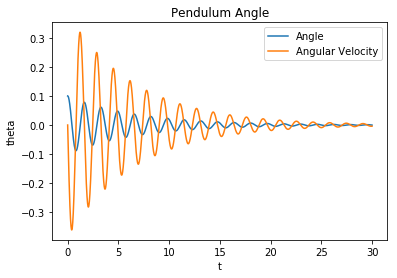

In [8]:
# RHSWrapper handles evaluating the dynamics model 
f = RHSWrapper(rhs, [q, dq],
               [m, l,    g,  mu], # params
               [1, 1, -9.8, 0.1]) # values

ts = np.linspace(0, 30, 3000) # time steps (milliseconds)
x0 = [0.1, 0] # initial condition
xs = odeint(f.step, x0, ts) # run the simulation

plt.plot(ts, xs[:,0], label="Angle")
plt.plot(ts, xs[:,1], label="Angular Velocity")   
plt.legend()
plt.title('Pendulum Angle')
plt.xlabel('t')
plt.ylabel('theta')